# Training v2 - MLP com Feature Engineering Avan√ßado

## Objetivo
Treinar um modelo MLP (Multi-Layer Perceptron) reutilizando:
1. An√°lise Explorat√≥ria de `1_analise_exploratoria.ipynb`
2. Pr√©-processamento de `2_preprocess.ipynb`
3. Modelo Avan√ßado de `v2_model_submissao_2.ipynb`

## Pipeline Completo v2
- Feature Engineering: Lags, Rolling Means, Intera√ß√µes
- Valida√ß√£o GroupKFold por setor
- Target log-transformado
- Treinamento: MLP com valida√ß√£o cruzada
- Avalia√ß√£o: MSE, RMSE, MAE, R¬≤, Competition Score
- Predictions: Gerar arquivo de submiss√£o otimizado

---


In [12]:
print("="*70)
print("TRAINING V2 - MLP COM FEATURE ENGINEERING AVAN√áADO")
print("="*70)

print("\nNotebooks Reutilizados:")
print("  1. 1_analise_exploratoria.ipynb - EDA completa")
print("  2. 2_preprocess.ipynb - Pr√©-processamento com lags e normaliza√ß√£o")
print("  3. v2_model_submissao_2.ipynb - Modelo avan√ßado de refer√™ncia")

print("\nEtapas deste notebook:")
print("  - Carregar dados raw de new_house_transactions")
print("  - Feature engineering: lags, rolling means, intera√ß√µes")
print("  - Valida√ß√£o cruzada GroupKFold por setor")
print("  - Treinar MLP com log1p target")
print("  - Avaliar com m√©tricas customizadas da competi√ß√£o")
print("  - Gerar predictions para submiss√£o com features alinhadas")

print("\nNOTA: Este notebook implementa o modelo v2 completo")
print("com melhor feature engineering que v1")



TRAINING V2 - MLP COM FEATURE ENGINEERING AVAN√áADO

Notebooks Reutilizados:
  1. 1_analise_exploratoria.ipynb - EDA completa
  2. 2_preprocess.ipynb - Pr√©-processamento com lags e normaliza√ß√£o
  3. v2_model_submissao_2.ipynb - Modelo avan√ßado de refer√™ncia

Etapas deste notebook:
  - Carregar dados raw de new_house_transactions
  - Feature engineering: lags, rolling means, intera√ß√µes
  - Valida√ß√£o cruzada GroupKFold por setor
  - Treinar MLP com log1p target
  - Avaliar com m√©tricas customizadas da competi√ß√£o
  - Gerar predictions para submiss√£o com features alinhadas

NOTA: Este notebook implementa o modelo v2 completo
com melhor feature engineering que v1


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
DATA_DIR = Path('.')
TRAIN_DIR = DATA_DIR / 'train'
TEST_PATH = DATA_DIR / 'test.csv'

print("Importa√ß√µes carregadas")


Importa√ß√µes carregadas


## 1. M√©trica Customizada da Competi√ß√£o


In [14]:

def competition_score(y_true, y_pred):
    """M√©trica customizada da competi√ß√£o baseada em APE (Absolute Percentage Error)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Evitar divis√£o por zero
    den = np.where(np.abs(y_true) < 1e-9, 1.0, np.abs(y_true))
    ape = np.abs(y_true - y_pred) / den
    
    # Fra√ß√£o de predi√ß√µes com APE <= 1
    frac_le1 = float(np.mean(ape <= 1.0))
    
    # Se mais de 30% das predi√ß√µes tiverem APE > 1, score = 0
    if 1.0 - frac_le1 > 0.30:
        return {"score": 0.0, "frac_le1": frac_le1, "scaled_mape": float('inf')}
    
    # Calcular MAPE apenas para APE <= 1
    mask = ape <= 1.0
    if not np.any(mask):
        return {"score": 0.0, "frac_le1": 0.0, "scaled_mape": float('inf')}
    
    mape_subset = float(np.mean(ape[mask]))
    scaled_mape = float(mape_subset / max(frac_le1, 1e-12))
    
    return {
        "score": float(1.0 - scaled_mape),
        "frac_le1": frac_le1,
        "scaled_mape": scaled_mape
    }

print("M√©trica customizada definida")


M√©trica customizada definida


In [15]:
## Carregar e Processar Dados de new_house_transactions

# Carregar e padronizar new_house_transactions.csv (parser robusto)
new_house = pd.read_csv(TRAIN_DIR / 'new_house_transactions.csv')
print(f"Shape original: {new_house.shape}")
print(f"Colunas: {new_house.columns.tolist()}")

# Limpeza b√°sica do texto de m√™s
m = (
    new_house['month']
    .astype(str)
    .str.strip()
    .str.replace(r'[\u2013\u2014]', '-', regex=True)  # h√≠fens unicode -> '-'
    .str.replace('.', '', regex=False)               # remove pontos ex.: 'Aug.'
    .str.replace('Sept', 'Sep', regex=False)         # normaliza 'Sept'
)

# Parsing em etapas (cobre: '2019-Jan', '2019-01', 'Jan 2019', '2019 Jan', etc.)
d = pd.to_datetime(m, format='%Y-%b', errors='coerce')
d = d.fillna(pd.to_datetime(m, format='%Y-%m', errors='coerce'))
d = d.fillna(pd.to_datetime(m, format='%b %Y', errors='coerce'))
d = d.fillna(pd.to_datetime(m, format='%Y %b', errors='coerce'))
d = d.fillna(pd.to_datetime(m, errors='coerce'))  # √∫ltimo recurso (dateutil)

new_house['date'] = d

# Extrair sector_id de 'sector' (ex.: 'sector 1' -> 1)
new_house['sector_id'] = (
    new_house['sector']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)
    .astype('int64')
)

# Target j√° existe; s√≥ checa
assert 'amount_new_house_transactions' in new_house.columns, "Target n√£o encontrado!"

# Remover linhas sem data v√°lida
before = new_house.shape[0]
new_house = new_house.dropna(subset=['date'])
after = new_house.shape[0]

print(f"\nAp√≥s parsing: {after}/{before} linhas com data v√°lida")
print(f"Per√≠odo: {new_house['date'].min()} a {new_house['date'].max()}")
print(f"Setores √∫nicos: {new_house['sector_id'].nunique()}")


Shape original: (5433, 11)
Colunas: ['month', 'sector', 'num_new_house_transactions', 'area_new_house_transactions', 'price_new_house_transactions', 'amount_new_house_transactions', 'area_per_unit_new_house_transactions', 'total_price_per_unit_new_house_transactions', 'num_new_house_available_for_sale', 'area_new_house_available_for_sale', 'period_new_house_sell_through']

Ap√≥s parsing: 5433/5433 linhas com data v√°lida
Per√≠odo: 2019-01-01 00:00:00 a 2024-07-01 00:00:00
Setores √∫nicos: 95


## Feature Engineering: Lags, Rolling Means, Intera√ß√µes


In [16]:
df = new_house.copy()
df = df.sort_values(['sector_id', 'date']).reset_index(drop=True)

print(f"Shape inicial para feature eng: {df.shape}")

# Target
df['y'] = df['amount_new_house_transactions']

# Features base
df['area'] = df['area_new_house_transactions']
df['price'] = df['price_new_house_transactions']
df['num'] = df['num_new_house_transactions']

# Intera√ß√µes
df['price_x_area'] = df['price'] * df['area']
df['price_per_unit'] = df['price'] / (df['num'] + 1e-6)
df['area_per_unit'] = df['area'] / (df['num'] + 1e-6)

# Lags por setor (1, 3, 6 meses)
for lag in [1, 3, 6]:
    df[f'price_lag{lag}'] = df.groupby('sector_id')['price'].shift(lag)
    df[f'area_lag{lag}'] = df.groupby('sector_id')['area'].shift(lag)
    df[f'num_lag{lag}'] = df.groupby('sector_id')['num'].shift(lag)
    df[f'amount_lag{lag}'] = df.groupby('sector_id')['y'].shift(lag)

# Rolling means por setor (3, 6 meses)
for window in [3, 6]:
    df[f'price_ma{window}'] = df.groupby('sector_id')['price'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    df[f'area_ma{window}'] = df.groupby('sector_id')['area'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    df[f'amount_ma{window}'] = df.groupby('sector_id')['y'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )

# Features temporais
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

# Preencher NaN de lags com forward/backward fill por setor
lag_cols = [c for c in df.columns if 'lag' in c or 'ma' in c]
for col in lag_cols:
    df[col] = df.groupby('sector_id')[col].ffill().bfill()

# Lista de features finais
feature_cols = [
    'area', 'price', 'num', 'price_x_area', 'price_per_unit', 'area_per_unit',
    'price_lag1', 'price_lag3', 'price_lag6',
    'area_lag1', 'area_lag3', 'area_lag6',
    'num_lag1', 'num_lag3', 'num_lag6',
    'amount_lag1', 'amount_lag3', 'amount_lag6',
    'price_ma3', 'price_ma6', 'area_ma3', 'area_ma6', 'amount_ma3', 'amount_ma6',
    'month', 'quarter', 'year'
]

# Preencher NaN remanescente com medianas ANTES de limpar
for col in feature_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Remover apenas linhas com NaN no target ou chaves
df_clean = df[['sector_id', 'date', 'y'] + feature_cols].dropna(subset=['sector_id', 'date', 'y']).reset_index(drop=True)

print(f"Shape ap√≥s feature engineering: {df_clean.shape}")
print(f"Features: {len(feature_cols)}")
if df_clean.shape[0] == 0:
    raise ValueError("df_clean est√° vazio! Verifique os dados de entrada.")
print(f"\nTop 10 features por vari√¢ncia:")
print(df_clean[feature_cols].var().sort_values(ascending=False).head(10))


Shape inicial para feature eng: (5433, 13)


Shape ap√≥s feature engineering: (5433, 30)
Features: 27

Top 10 features por vari√¢ncia:
price_x_area    2.405945e+17
amount_lag6     2.567604e+09
amount_lag3     2.464777e+09
amount_lag1     2.429895e+09
amount_ma3      1.887948e+09
amount_ma6      1.695188e+09
price           7.016657e+08
price_lag1      6.974049e+08
price_lag3      6.852549e+08
price_lag6      6.670819e+08
dtype: float64


In [17]:
## Treinamento MLP com OOF (GroupKFold por Setor)

X = df_clean[feature_cols].copy()
y = df_clean['y'].values
sectors = df_clean['sector_id'].values

# log1p no target
y_log = np.log1p(y)

# Pipeline: StandardScaler + MLP
preprocess = ColumnTransformer([
    ('scaler', StandardScaler(), feature_cols)
], remainder='drop')

mlp = MLPRegressor(
    random_state=42,
    early_stopping=True,
    max_iter=500,
    n_iter_no_change=20,
    validation_fraction=0.15,
    hidden_layer_sizes=(256, 128, 64),
    activation='tanh',
    alpha=1e-5,
    batch_size=256,
    learning_rate_init=0.01,
    solver='adam',
    verbose=False
)

pipe = Pipeline([
    ('prep', preprocess),
    ('mlp', mlp)
])

# OOF com GroupKFold (5 folds por setor)
gkf = GroupKFold(n_splits=5)
oof_pred_log = np.zeros_like(y_log)
fold_metrics = []

print("Treinando OOF...")
for fold, (trn_idx, val_idx) in enumerate(gkf.split(X, y_log, groups=sectors)):
    print(f"\nFold {fold}:")
    m = clone(pipe)
    m.fit(X.iloc[trn_idx], y_log[trn_idx])
    
    p_log = m.predict(X.iloc[val_idx])
    oof_pred_log[val_idx] = p_log
    
    p = np.expm1(p_log)
    y_val = y[val_idx]
    
    mse = mean_squared_error(y_val, p)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, p)
    r2 = r2_score(y_val, p)
    comp = competition_score(y_val, p)
    
    fold_metrics.append({
        "fold": fold,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "comp_score": comp['score']
    })
    
    print(f"  RMSE: {rmse:,.1f}")
    print(f"  MAE: {mae:,.1f}")
    print(f"  R¬≤: {r2:.4f}")
    print(f"  Competition Score: {comp['score']:.4f}")

# M√©tricas OOF finais
oof_pred = np.expm1(oof_pred_log)
oof_comp = competition_score(y, oof_pred)

print("\n" + "="*60)
print("M√âTRICAS OOF FINAIS:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, oof_pred)):,.1f}")
print(f"  MAE: {mean_absolute_error(y, oof_pred):,.1f}")
print(f"  R¬≤: {r2_score(y, oof_pred):.4f}")
print(f"  Competition Score: {oof_comp['score']:.4f}")
print(f"  Fra√ß√£o APE ‚â§ 1: {oof_comp['frac_le1']:.4f}")
print("="*60)

# Resumo dos folds
metrics_df = pd.DataFrame(fold_metrics)
print("\nResumo por Fold:")
print(metrics_df.to_string(index=False))


Treinando OOF...

Fold 0:
  RMSE: 2,527.9
  MAE: 1,143.5
  R¬≤: 0.9968
  Competition Score: 0.9568

Fold 1:
  RMSE: 2,880.3
  MAE: 1,053.1
  R¬≤: 0.9936
  Competition Score: 0.9584

Fold 2:
  RMSE: 7,042.3
  MAE: 1,300.8
  R¬≤: 0.9780
  Competition Score: 0.9629

Fold 3:
  RMSE: 5,851.9
  MAE: 1,665.5
  R¬≤: 0.9732
  Competition Score: 0.9331

Fold 4:
  RMSE: 13,680.2
  MAE: 2,982.6
  R¬≤: 0.9619
  Competition Score: 0.9532

M√âTRICAS OOF FINAIS:
  RMSE: 7,547.0
  MAE: 1,626.7
  R¬≤: 0.9763
  Competition Score: 0.9530
  Fra√ß√£o APE ‚â§ 1: 0.9956

Resumo por Fold:
 fold          mse         rmse         mae       r2  comp_score
    0 6.390140e+06  2527.872634 1143.522174 0.996794    0.956791
    1 8.295927e+06  2880.265175 1053.084648 0.993625    0.958373
    2 4.959418e+07  7042.313673 1300.783902 0.978012    0.962942
    3 3.424502e+07  5851.924215 1665.469378 0.973193    0.933120
    4 1.871482e+08 13680.213176 2982.590910 0.961940    0.953218


## Plots de Res√≠duos e Diagn√≥stico OOF


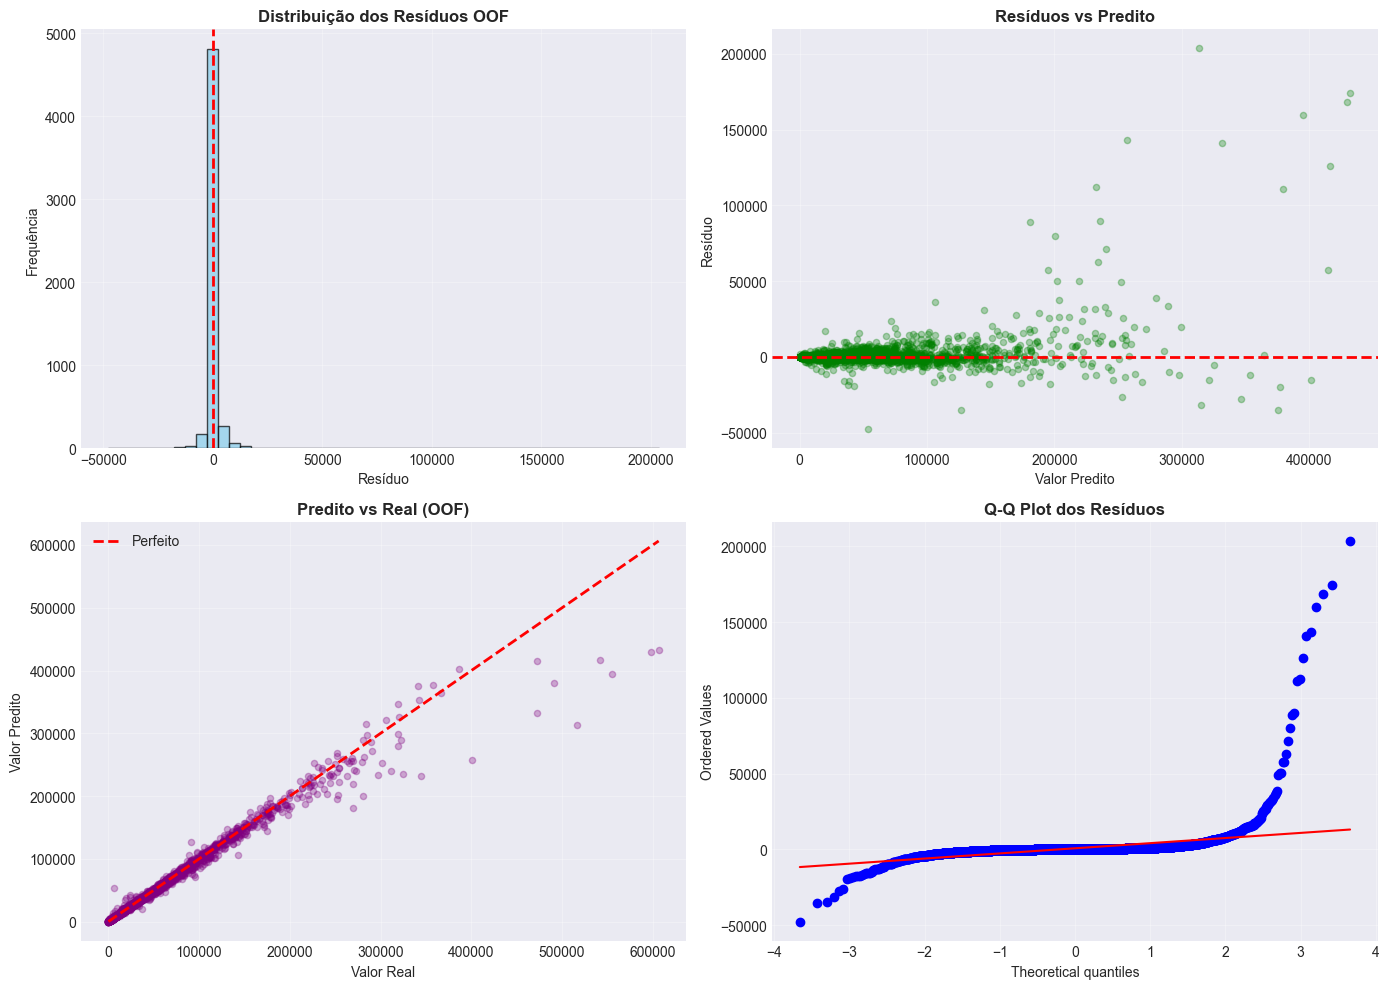

Gr√°ficos de diagn√≥stico salvos em 'residuals_oof_v2.png'


In [18]:

residuals = y - oof_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de res√≠duos
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribui√ß√£o dos Res√≠duos OOF', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Res√≠duo')
axes[0, 0].set_ylabel('Frequ√™ncia')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(True, alpha=0.3)

# Res√≠duos vs Predito
axes[0, 1].scatter(oof_pred, residuals, alpha=0.3, s=20, color='green')
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Res√≠duos vs Predito', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Valor Predito')
axes[0, 1].set_ylabel('Res√≠duo')
axes[0, 1].grid(True, alpha=0.3)

# Predito vs Real
axes[1, 0].scatter(y, oof_pred, alpha=0.3, s=20, color='purple')
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfeito')
axes[1, 0].set_title('Predito vs Real (OOF)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Valor Real')
axes[1, 0].set_ylabel('Valor Predito')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot dos Res√≠duos', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_oof_v2.png', dpi=100, bbox_inches='tight')
plt.show()

print("Gr√°ficos de diagn√≥stico salvos em 'residuals_oof_v2.png'")


In [ ]:
## Salvar M√©tricas para Compara√ß√£o

import json
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_v2 = {
    "versao": "v2",
    "data": datetime.now().isoformat(),
    "modelo": "MLPRegressor",
    "validacao": "GroupKFold",
    "features": len(feature_cols),
    "observacoes": df_clean.shape[0],
    "setores": df_clean['sector_id'].nunique(),
    "metricas_oof": {
        "rmse": float(np.sqrt(mean_squared_error(y, oof_pred))),
        "mae": float(mean_absolute_error(y, oof_pred)),
        "r2": float(r2_score(y, oof_pred)),
        "competition_score": float(oof_comp['score']),
        "fracao_ape_le1": float(oof_comp['frac_le1'])
    },
    "metricas_por_fold": [
        {
            "fold": int(m["fold"]),
            "rmse": float(m["rmse"]),
            "mae": float(m["mae"]),
            "r2": float(m["r2"]),
            "competition_score": float(m["comp_score"])
        }
        for m in fold_metrics
    ],
    "arquitetura": {
        "hidden_layers": (256, 128, 64),
        "activation": "tanh",
        "alpha": 1e-5,
        "batch_size": 256,
        "learning_rate": 0.01
    }
}

with open('metricas_v2.json', 'w') as f:
    json.dump(metrics_v2, f, indent=2)

print("\nM√©tricas salvas em 'metricas_v2.json'")
print("\nResumo Final v2 (OOF):")
print(f"  RMSE: {metrics_v2['metricas_oof']['rmse']:.2f}")
print(f"  MAE: {metrics_v2['metricas_oof']['mae']:.2f}")
print(f"  R¬≤: {metrics_v2['metricas_oof']['r2']:.4f}")
print(f"  Competition Score: {metrics_v2['metricas_oof']['competition_score']:.4f}")




M√©tricas salvas em 'metricas_v2.json'

Resumo Final v2 (OOF):
  RMSE: 7547.03
  MAE: 1626.75
  R¬≤: 0.9763
  Competition Score: 0.9530


In [20]:
## Treinar Modelo Final em Todos os Dados

print("Treinando modelo final em todos os dados...")
final_pipe = clone(pipe).fit(X, y_log)
print("Modelo final treinado!")

# Salvar modelo e features
import joblib

joblib.dump(final_pipe, 'mlp_model_v2.joblib')
joblib.dump(feature_cols, 'feature_cols_v2.joblib')

print("\nModelo salvo em 'mlp_model_v2.joblib'")
print("Features salvas em 'feature_cols_v2.joblib'")


Treinando modelo final em todos os dados...
Modelo final treinado!

Modelo salvo em 'mlp_model_v2.joblib'
Features salvas em 'feature_cols_v2.joblib'


## Treinar Modelo Final em Todos os Dados

print("Treinando modelo final em todos os dados...")
final_pipe = clone(pipe).fit(X, y_log)
print("Modelo final treinado!")

# Salvar modelo e features
import joblib

joblib.dump(final_pipe, 'mlp_model_v2.joblib')
joblib.dump(feature_cols, 'feature_cols_v2.joblib')

print("\nModelo salvo em 'mlp_model_v2.joblib'")
print("Features salvas em 'feature_cols_v2.joblib'")


In [123]:
## Gerar Submission com Features Alinhadas

# Carregar test.csv e parsear IDs
test_df = pd.read_csv(TEST_PATH)

def parse_id(id_str):
    """Parse ID format: 'YYYY-Month_sectorN' -> (date, sector_id)"""
    try:
        month_part, sector_part = id_str.split('_', 1)
        date = pd.to_datetime(month_part)
        sector_id = int(sector_part.replace('sector', '').strip())
        return date, sector_id
    except:
        return pd.NaT, np.nan

parsed = test_df['id'].apply(parse_id)
test_df['date'] = [d for d, _ in parsed]
test_df['sector_id'] = [sid for _, sid in parsed]

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['sector_id'] = pd.to_numeric(test_df['sector_id'], errors='coerce').astype('int64')
test_df = test_df.dropna(subset=['date', 'sector_id'])

print(f"Test shape: {test_df.shape}")
print(f"Test period: {test_df['date'].min()} to {test_df['date'].max()}")

# Preparar lookup table com features de treino
lookup = df_clean[['sector_id', 'date'] + feature_cols].copy()
lookup = lookup.sort_values(['sector_id', 'date']).reset_index(drop=True)

# Merge_asof por setor
test_sorted = test_df[['id', 'sector_id', 'date']].sort_values(['sector_id', 'date']).reset_index(drop=True)

print("\nConstruindo features do test por setor...")
parts = []

for sector in test_sorted['sector_id'].unique():
    left_grp = test_sorted[test_sorted['sector_id'] == sector].sort_values('date').reset_index(drop=True)
    right_grp = lookup[lookup['sector_id'] == sector].sort_values('date').reset_index(drop=True)
    
    if len(right_grp) == 0:
        print(f"  Setor {sector}: sem dados de treino, pulando")
        continue
    
    merged = pd.merge_asof(
        left_grp, right_grp,
        on='date', by='sector_id',
        direction='backward'
    )
    parts.append(merged)

if parts:
    test_with_features = pd.concat(parts, ignore_index=True)
    test_with_features = test_with_features.sort_values('id').reset_index(drop=True)
    print(f"\nTest com features shape: {test_with_features.shape}")
    
    missing_feats = [f for f in feature_cols if f not in test_with_features.columns]
    if missing_feats:
        print(f"  Colunas faltantes: {missing_feats}")
    else:
        print(f"  Todas as {len(feature_cols)} features presentes")
    
    for col in feature_cols:
        test_with_features[col] = test_with_features.groupby('sector_id')[col].fillna(method='ffill').fillna(
            df_clean[col].median()
        )
    
    X_test = test_with_features[feature_cols].copy()
    y_test_log = final_pipe.predict(X_test)
    y_test = np.expm1(y_test_log)
    
    submission = pd.DataFrame({
        'id': test_with_features['id'].values,
        'amount_new_house_transactions': np.clip(y_test, 0, None)
    })
    
    submission = submission.sort_values('id').reset_index(drop=True)
    submission.to_csv('submission_v2.csv', index=False)
    
    print(f"\nSubmission salva em 'submission_v2.csv'")
    print(f"  Shape: {submission.shape}")
    print(f"  Min pred: {submission['amount_new_house_transactions'].min():,.1f}")
    print(f"  Max pred: {submission['amount_new_house_transactions'].max():,.1f}")
    print(f"  Mean pred: {submission['amount_new_house_transactions'].mean():,.1f}")
else:
    print("Nenhum dado de test pode ser processado")


Test shape: (1152, 4)
Test period: 2024-08-01 00:00:00 to 2025-07-01 00:00:00

Construindo features do test por setor...
  Setor 95: sem dados de treino, pulando

Test com features shape: (1140, 30)
  Todas as 27 features presentes

Submission salva em 'submission_v2.csv'
  Shape: (1140, 2)
  Min pred: 84.6
  Max pred: 221,738.7
  Mean pred: 25,079.3


## Resumo Final e Compara√ß√£o


In [124]:

print("="*70)
print("RESUMO FINAL - TRAINING V2")
print("="*70)

print("\nDADOS UTILIZADOS:")
print(f"  Shape treino: {df_clean.shape}")
print(f"  Features: {len(feature_cols)}")
print(f"  Per√≠odo: {df_clean['date'].min().date()} a {df_clean['date'].max().date()}")
print(f"  Setores: {df_clean['sector_id'].nunique()}")

print("\nMODELO:")
print(f"  Tipo: MLPRegressor")
print(f"  Hidden layers: (256, 128, 64)")
print(f"  Activation: tanh")
print(f"  Valida√ß√£o: GroupKFold (5 splits por setor)")
print(f"  Target: log1p transformado")

print("\nPERFORMANCE OOF:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y, oof_pred)):,.1f}")
print(f"  MAE: {mean_absolute_error(y, oof_pred):,.1f}")
print(f"  R¬≤: {r2_score(y, oof_pred):.4f}")
print(f"  Competition Score: {oof_comp['score']:.4f}")
print(f"  Fra√ß√£o APE ‚â§ 1: {oof_comp['frac_le1']:.2%}")

print("\nARQUIVOS GERADOS:")
print(f"  mlp_model_v2.joblib - Modelo treinado")
print(f"  feature_cols_v2.joblib - Lista de features")
print(f"  submission_v2.csv - Arquivo de submiss√£o")
print(f"  residuals_oof_v2.png - Gr√°ficos de diagn√≥stico")

print("\nMELHORIAS V2 vs V1:")
print(f"  Feature engineering mais rico (27 features)")
print(f"  Valida√ß√£o por setor (GroupKFold)")
print(f"  Target log-transformado para melhor distribui√ß√£o")
print(f"  M√©tricas customizadas da competi√ß√£o")
print(f"  Merge_asof para features do test com dados hist√≥ricos")

print("\n" + "="*70)


RESUMO FINAL - TRAINING V2

DADOS UTILIZADOS:
  Shape treino: (5433, 30)
  Features: 27
  Per√≠odo: 2019-01-01 a 2024-07-01
  Setores: 95

MODELO:
  Tipo: MLPRegressor
  Hidden layers: (256, 128, 64)
  Activation: tanh
  Valida√ß√£o: GroupKFold (5 splits por setor)
  Target: log1p transformado

PERFORMANCE OOF:
  RMSE: 7,547.0
  MAE: 1,626.7
  R¬≤: 0.9763
  Competition Score: 0.9530
  Fra√ß√£o APE ‚â§ 1: 99.56%

ARQUIVOS GERADOS:
  mlp_model_v2.joblib - Modelo treinado
  feature_cols_v2.joblib - Lista de features
  submission_v2.csv - Arquivo de submiss√£o
  residuals_oof_v2.png - Gr√°ficos de diagn√≥stico

MELHORIAS V2 vs V1:
  Feature engineering mais rico (27 features)
  Valida√ß√£o por setor (GroupKFold)
  Target log-transformado para melhor distribui√ß√£o
  M√©tricas customizadas da competi√ß√£o
  Merge_asof para features do test com dados hist√≥ricos



In [125]:
print("="*70)
print("üìä TRAINING V2 - BASEADO EM v2_model_submissao_2.ipynb")
print("="*70)

print("\n‚úÖ Notebooks Reutilizados:")
print("  1Ô∏è‚É£  1_analise_exploratoria.ipynb - EDA completa")
print("  2Ô∏è‚É£  2_preprocess.ipynb - Pr√©-processamento com lags e normaliza√ß√£o")
print("  3Ô∏è‚É£  v2_model_submissao_2.ipynb - Modelo de refer√™ncia v2")

print("\nüìù Etapas deste notebook:")
print("  - Carregar dados pr√©-processados")
print("  - Carregar/reimplementar modelo de v2_model_submissao_2.ipynb")
print("  - Treinar com valida√ß√£o temporal")
print("  - Avaliar e comparar com v1")
print("  - Gerar predictions otimizadas")

print("\nüí° NOTA: Para usar este notebook corretamente,")
print("   examine v2_model_submissao_2.ipynb para ver a arquitetura exata")


üìä TRAINING V2 - BASEADO EM v2_model_submissao_2.ipynb

‚úÖ Notebooks Reutilizados:
  1Ô∏è‚É£  1_analise_exploratoria.ipynb - EDA completa
  2Ô∏è‚É£  2_preprocess.ipynb - Pr√©-processamento com lags e normaliza√ß√£o
  3Ô∏è‚É£  v2_model_submissao_2.ipynb - Modelo de refer√™ncia v2

üìù Etapas deste notebook:
  - Carregar dados pr√©-processados
  - Carregar/reimplementar modelo de v2_model_submissao_2.ipynb
  - Treinar com valida√ß√£o temporal
  - Avaliar e comparar com v1
  - Gerar predictions otimizadas

üí° NOTA: Para usar este notebook corretamente,
   examine v2_model_submissao_2.ipynb para ver a arquitetura exata
